In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astroquery.sdss import SDSS
import urllib
import IPython.display

from sdss_tools import sdss_jpg, sdss_fits, sdss_spectra, sdss_template

%matplotlib inline

We will analyze the SDSS-DR9 Quasar Catalog (DR9Q). More information in the following link https://www.sdss3.org/dr9/algorithms/qso_catalog.php

In [7]:
cat_file='../data/DR9Q.fits'
hdu = fits.open(cat_file)
hdu.info()

cat_data=hdu[1].data
cat_data.columns

Filename: ../data/DR9Q.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      16   (15819,)     uint8   
1    DR9Q        BinTableHDU    536   87822R x 131C   [18A, D, D, J, J, J, J, D, D, D, J, D, D, D, D, D, D, I, K, K, K, J, J, J, J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D, D, J, D, D, J, D, D, D, D, D, I, J, 3A, I, I, 19A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, J, D, D, D, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


ColDefs(
    name = 'SDSS_NAME'; format = '18A'; unit = '-'
    name = 'RA'; format = 'D'; unit = 'DEGREE'
    name = 'DEC'; format = 'D'; unit = 'DEGREE'
    name = 'THING_ID'; format = 'J'; unit = '-'
    name = 'PLATE'; format = 'J'; unit = '-'
    name = 'MJD'; format = 'J'; unit = '-'
    name = 'FIBERID'; format = 'J'; unit = '-'
    name = 'Z_VI'; format = 'D'; unit = '-'
    name = 'Z_PIPE'; format = 'D'; unit = '-'
    name = 'ERR_ZPIPE'; format = 'D'; unit = '-'
    name = 'ZWARNING'; format = 'J'; unit = '-'
    name = 'Z_PCA'; format = 'D'; unit = '-'
    name = 'ERR_ZPCA'; format = 'D'; unit = '-'
    name = 'PCA_QUAL'; format = 'D'; unit = '-'
    name = 'Z_CIV'; format = 'D'; unit = '-'
    name = 'Z_CIII'; format = 'D'; unit = '-'
    name = 'Z_MGII'; format = 'D'; unit = '-'
    name = 'SDSS_MORPHO'; format = 'I'; unit = '-'
    name = 'BOSS_TARGET1'; format = 'K'; unit = '-'
    name = 'ANCILLARY_TARGET1'; format = 'K'; unit = '-'
    name = 'ANCILLARY_TARGET2'; forma

In [9]:
n=cat_data.size
gv=np.random.choice(n,10000, replace=False)

coo = SkyCoord(ra=cat_data['RA'][gv]*u.degree, dec=cat_data['DEC'][gv]*u.degree)
coo.galactic.l.degree

d = {'sdss_name':cat_data['SDSS_NAME'][gv], 'ra':cat_data['RA'][gv], 'dec':cat_data['DEC'][gv], 'l':coo.galactic.l.degree, 'b':coo.galactic.b.degree, 'z':cat_data['Z_PIPE'][gv], 'M_i':cat_data['MI'][gv], 'fwhm_CIV':cat_data['FWHM_CIV'][gv], 'fwhm_CIII':cat_data['FWHM_CIII'][gv], 'fwhm_MGII':cat_data['FWHM_MGII'][gv]}

data=pd.DataFrame(d, columns=['sdss_name', 'ra', 'dec', 'l', 'b', 'M_i','z','fwhm_CIV', 'fwhm_CIII','fwhm_MGII'])
data.to_csv('../data/SDSS_quasars.csv')
data.head()

sdss_name          ra        dec           l          b  \
0  115830.12+015129.4  179.625509   1.858176  274.049359  61.724857   
1  084346.67+141849.1  130.944466  14.313663  212.125860  31.246123   
2  215358.79+073725.0  328.494988   7.623615   65.411885 -34.760058   
3  140147.51+381321.2  210.447961  38.222558   74.315481  71.554640   
4  125141.50+394727.2  192.922929  39.790906  122.709516  77.337237   

         M_i         z     fwhm_CIV     fwhm_CIII  fwhm_MGII  
0 -24.883405  2.537354  3212.622056   3867.502879       -1.0  
1 -24.491778  2.289456  5426.123689  10125.461206       -1.0  
2 -26.712757  3.824759  3109.362745   4942.238381       -1.0  
3 -23.703304  0.820447    -1.000000     -1.000000       -1.0  
4 -25.418257  2.341919  5273.938336   6362.551908       -1.0

In [10]:
def plot_mwd(ra,dec,org=0,title='Mollweide projection', projection='mollweide'):
    x = np.remainder(ra+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=projection, axisbg ='LightCyan')
    ax.scatter(np.radians(x),np.radians(dec), marker='o', s=5, facecolor='green', edgecolor='', alpha=0.5)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)

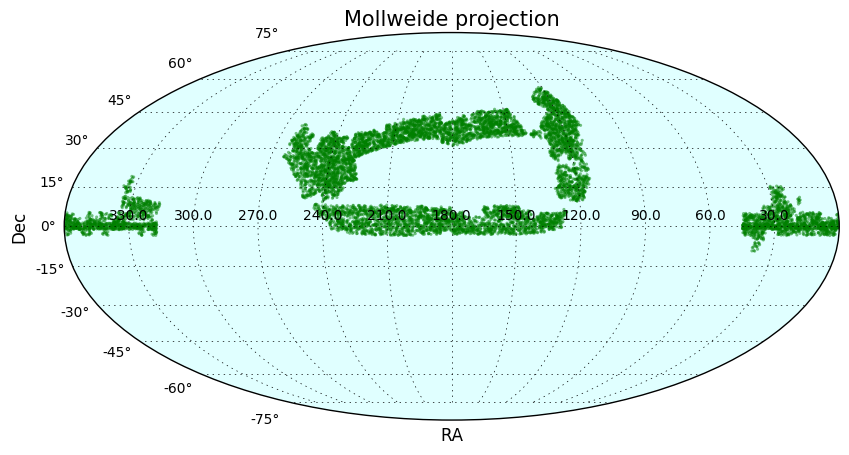

In [11]:
plot_mwd(data['ra'],data['dec'], org=180.)

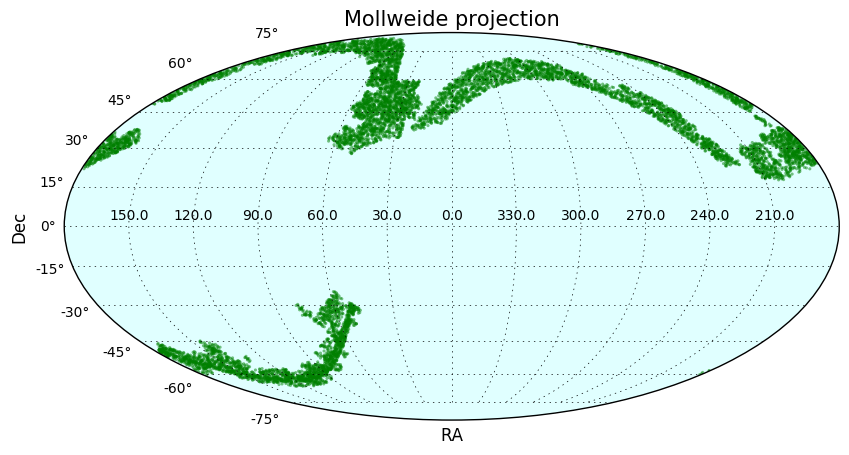

In [12]:
plot_mwd(data['l'],data['b'], org=0.)

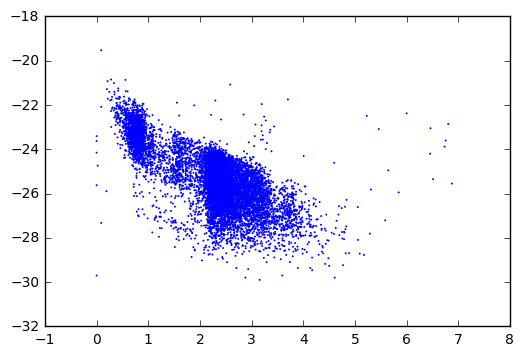

In [13]:
plt.scatter(data['z'],data['M_i'], edgecolor='', s=2)

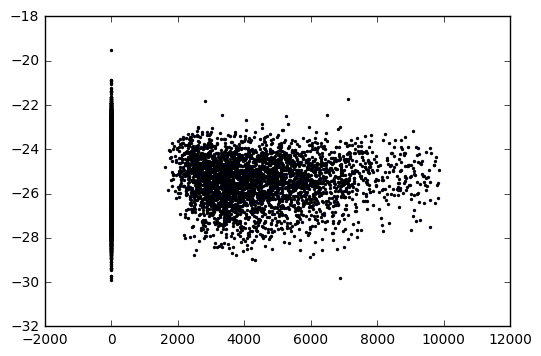

In [14]:
plt.scatter(data['fwhm_MGII'], data['M_i'], s=2)

(1000, 15000)

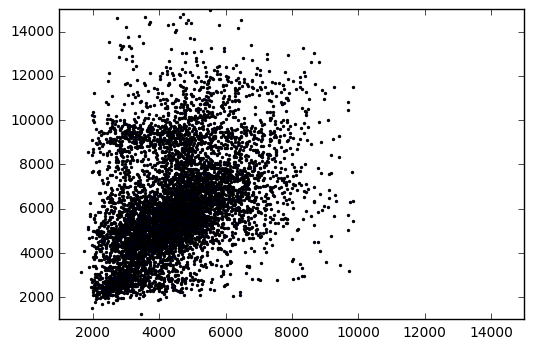

In [15]:
plt.scatter(data['fwhm_CIV'], data['fwhm_CIII'], s=2)
plt.xlim(1000,15000)
plt.ylim(1000,15000)

# Descarga del catalogo Galaxy Zoo

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astroquery.sdss import SDSS
import urllib
import IPython.display

from sdss_tools import sdss_jpg, sdss_fits, sdss_spectra, sdss_template

%matplotlib inline

In [18]:
cat_file='../data/GalaxyZoo1_DR_table2.csv'
cat_data=pd.read_csv(cat_file)
cat_data['P_S']=cat_data['P_CW']+cat_data['P_ACW']
cat_data.head()

OBJID           RA          DEC  NVOTE   P_EL   P_CW  P_ACW  \
0  587727178986356823  00:00:00.41  -10:22:25.7     59  0.610  0.034  0.000   
1  587727227300741210  00:00:00.74  -09:13:20.2     18  0.611  0.000  0.167   
2  587727225153257596  00:00:01.03  -10:56:48.0     68  0.735  0.029  0.000   
3  587730774962536596  00:00:01.38  +15:30:35.3     52  0.885  0.019  0.000   
4  587731186203885750  00:00:01.55  -00:05:33.3     59  0.712  0.000  0.000   

   P_EDGE   P_DK   P_MG   P_CS  P_EL_DEBIASED  P_CS_DEBIASED  SPIRAL  \
0   0.153  0.153  0.051  0.186          0.610          0.186       0   
1   0.222  0.000  0.000  0.389          0.203          0.797       1   
2   0.147  0.074  0.015  0.176          0.432          0.428       0   
3   0.058  0.019  0.019  0.077          0.885          0.077       0   
4   0.220  0.068  0.000  0.220          0.640          0.290       0   

   ELLIPTICAL  UNCERTAIN    P_S  
0           0          1  0.034  
1           0          0  0.167  
2           0          1  0.029  
3           1          0  0.019  
4           0          1  0.000

In [19]:
cat_elliptical=cat_data.query('P_EL >0.5').sort_values('P_EL',ascending=0)
cat_spiral=cat_data.query('P_S > 0.5').sort_values('P_S',ascending=0)
cat_edge=cat_data.query('P_EDGE >0.5').sort_values('P_EDGE',ascending=0)
cat_merger=cat_data.query('P_MG >0.5').sort_values('P_MG',ascending=0)

In [20]:
cat_penta=pd.concat([cat_elliptical[0:10],cat_spiral[0:10],cat_edge[0:10],cat_merger[0:10]])
cat_penta['ra']=Angle(cat_penta['RA'], unit=u.hourangle).degree
cat_penta['dec']=Angle(cat_penta['DEC'], unit=u.degree).degree
cat_penta=cat_penta[['OBJID','ra','dec']].reset_index(drop=True)

In [21]:
coo=SkyCoord(cat_penta['ra'], cat_penta['dec'], unit=(u.deg,u.deg))

for i in range(len(coo)):
    print 'Processing galaxy ', i
    result = SDSS.query_region(coo[i], spectro=True, photoobj_fields=['ra','dec','u','g','r','i','z'], specobj_fields=['z'], radius=2*u.arcsec)
    print result
    if result != None:
        if i==0:
            cat_sdss=result
        else:          
            cat_sdss.add_row(np.array(result)[0])

cat_sdss=np.array(cat_sdss)
np.random.shuffle(cat_sdss)
cat_sdss=pd.DataFrame(cat_sdss)
cat_sdss=cat_sdss.rename(columns = {'z1':'redshift'})

Processing galaxy  0
      ra           dec         u        g     ...    i        z         z1    
------------- ------------- -------- -------- ... -------- -------- ----------
138.357871656 52.9813126189 15.75001 13.81723 ... 12.62163 12.32539 0.02522517
Processing galaxy  1
      ra           dec         u        g       r       i        z        z1    
------------- ------------- -------- -------- ------ -------- ------- ----------
120.846227859 45.5310825107 18.11195 16.11806 15.151 14.69634 14.3422 0.06177348
Processing galaxy  2
      ra           dec         u        g     ...    i        z         z1   
------------- ------------- -------- -------- ... -------- -------- ---------
162.343668918 15.0603939134 19.89191 18.26566 ... 16.60344 16.29262 0.2101533
Processing galaxy  3


/usr/local/lib/python2.7/site-packages/astropy/table/table.py:2424: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  result = self.as_array() == other


      ra          dec         u        g       r        i       z         z1    
------------- ------------ -------- ------- -------- ------- -------- ----------
120.553392078 28.873272911 18.80657 16.8124 15.79818 15.3319 14.94717 0.08106873
Processing galaxy  4
      ra          dec         u        g        r       i       z         z1   
------------- ------------ -------- -------- -------- ------ -------- ---------
223.806326101 10.907129703 19.28682 17.17159 16.07723 15.642 15.27517 0.1274066
Processing galaxy  5
      ra            dec          u        g     ...    i       z        z1   
------------- --------------- -------- -------- ... -------- ------ ---------
14.0709188816 -0.953292558779 19.53343 17.36526 ... 15.81089 15.449 0.1402144
Processing galaxy  6
      ra           dec         u        g     ...    i        z         z1   
------------- ------------- -------- -------- ... -------- -------- ---------
150.171986912 45.4275327141 19.88002 18.12768 ... 16.82249 16.46

We write the SDSS subset catalog

In [24]:
cat_sdss.to_csv('../data/SDSS_galaxyzoo_sample_n40.csv',index=False, columns=['ra','dec','u','g','r','i','z'])
cat_sdss.head()

ra        dec         u         g         r         i         z
0  239.495541  22.325141  18.48617  17.00311  16.26324  15.88828  15.56575
1  206.784942  17.059916  18.68597  17.34896  16.78204  16.44462  16.24426
2  129.116325  10.645035  16.48803  14.97490  14.30069  13.93282  13.67800
3   14.070919  -0.953293  19.53343  17.36526  16.25612  15.81089  15.44900
4  206.697198  28.670485  19.56450  17.61060  17.05630  16.75068  16.55159

We read the SDSS subset catalog

In [25]:
cat_sdss=pd.read_csv('../data/SDSS_galaxyzoo_sample_n40.csv')
cat_sdss.head()

ra        dec         u         g         r         i         z
0  239.495541  22.325141  18.48617  17.00311  16.26324  15.88828  15.56575
1  206.784942  17.059916  18.68597  17.34896  16.78204  16.44462  16.24426
2  129.116325  10.645035  16.48803  14.97490  14.30069  13.93282  13.67800
3   14.070919  -0.953293  19.53343  17.36526  16.25612  15.81089  15.44900
4  206.697198  28.670485  19.56450  17.61060  17.05630  16.75068  16.55159

Procesando galaxia 0
Procesando galaxia 1
Procesando galaxia 2
Procesando galaxia 3
Procesando galaxia 4
Procesando galaxia 5
Procesando galaxia 6
Procesando galaxia 7


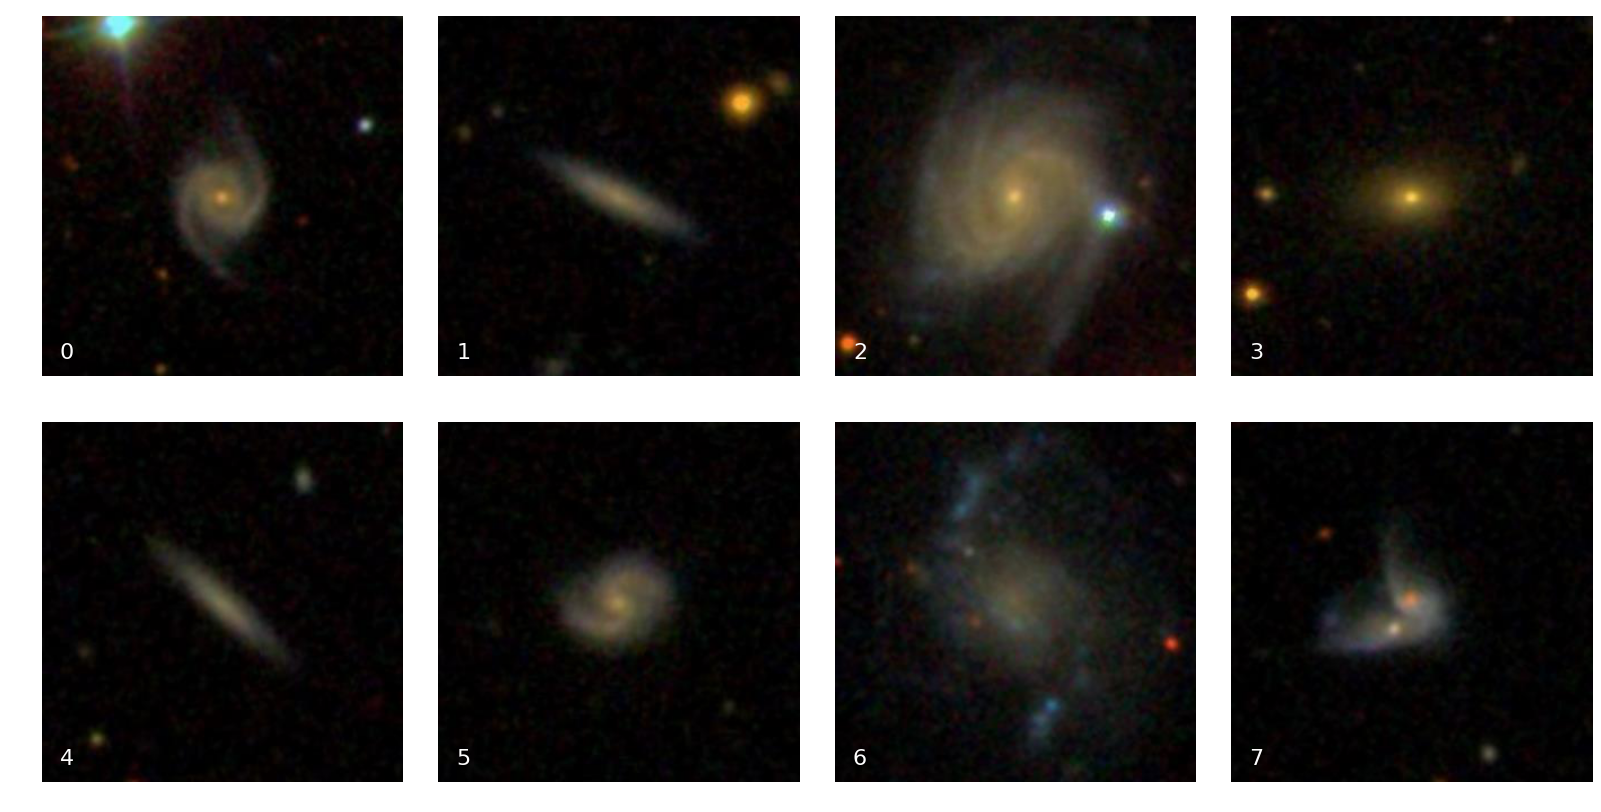

In [27]:
coo=SkyCoord(cat_sdss['ra'][0:8], cat_sdss['dec'][0:8], unit=(u.deg,u.deg))
sdss_jpg(coo)

Procesando galaxia 0


TimeoutError: Query timed out, time elapsed 60s

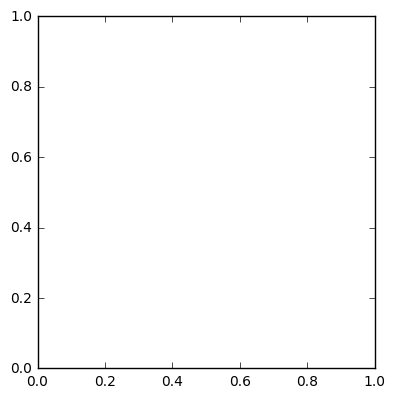

In [28]:
coo=SkyCoord(cat_sdss['ra'][0:8], cat_sdss['dec'][0:8], unit=(u.deg,u.deg))
sdss_fits(coo, filtro='g')

Procesando galaxia 1
Procesando galaxia 2
Procesando galaxia 3
Procesando galaxia 4
Procesando galaxia 5
Procesando galaxia 6
Procesando galaxia 7
Procesando galaxia 8
Procesando galaxia 9
Procesando galaxia 10
Procesando galaxia 11
Procesando galaxia 12
Procesando galaxia 13
Procesando galaxia 14
Procesando galaxia 15
Procesando galaxia 16
Procesando galaxia 17
Procesando galaxia 18
Procesando galaxia 19
Procesando galaxia 20
Procesando galaxia 21
Procesando galaxia 22
Procesando galaxia 23
Procesando galaxia 24
Procesando galaxia 25
Procesando galaxia 26
Procesando galaxia 27
Procesando galaxia 28
Procesando galaxia 29
Procesando galaxia 30
Procesando galaxia 31
Procesando galaxia 32
Procesando galaxia 33
Procesando galaxia 34
Procesando galaxia 35
Procesando galaxia 36
Procesando galaxia 37
Procesando galaxia 38
Procesando galaxia 39
Procesando galaxia 40


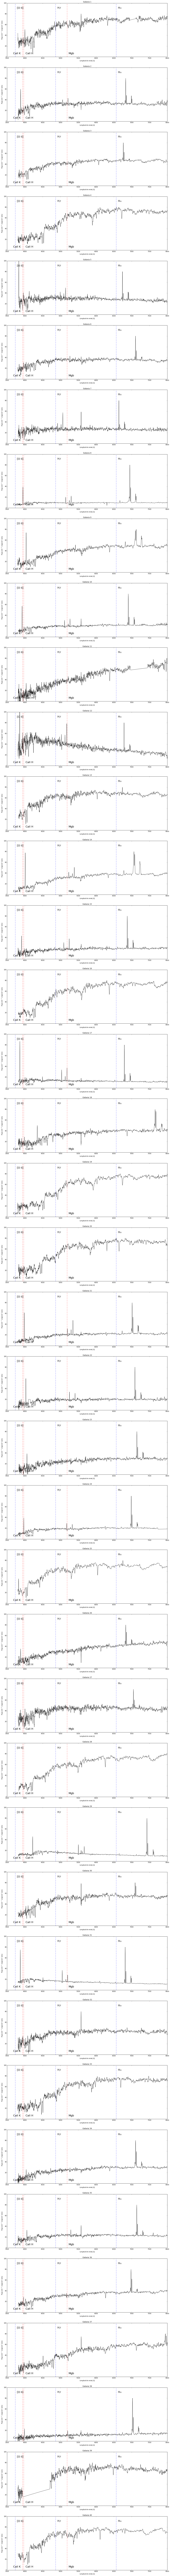

In [5]:
coo=SkyCoord(cat_sdss['ra'], cat_sdss['dec'], unit=(u.deg,u.deg))
sdss_spectra(coo)

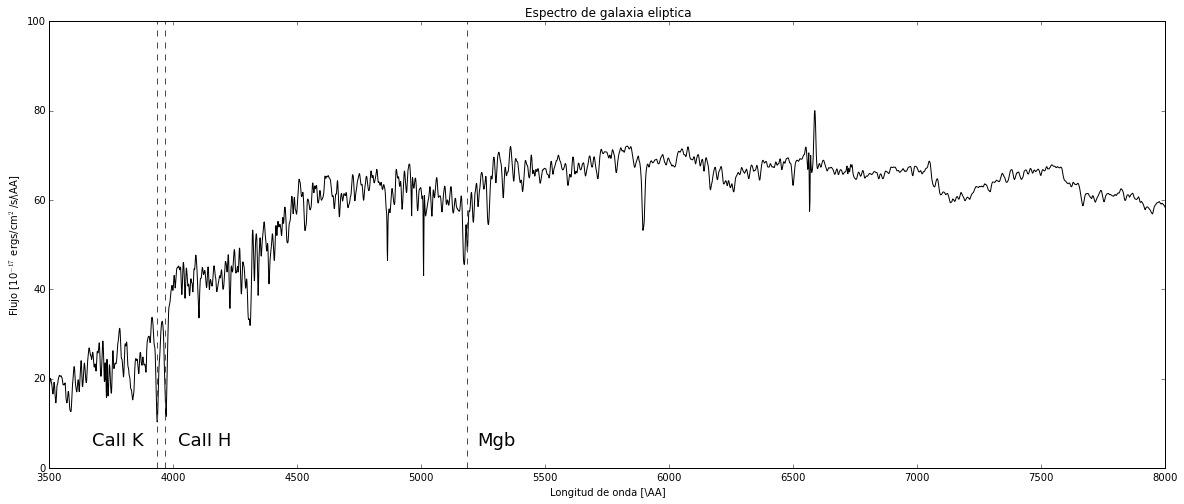

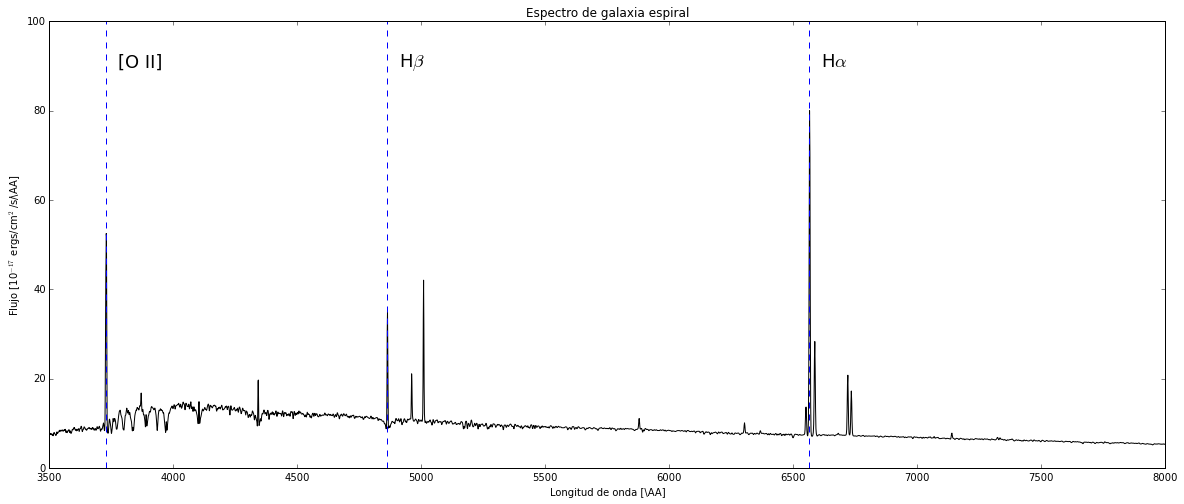

In [7]:
sdss_template(tipo='eliptica')
sdss_template(tipo='espiral')

In [31]:
x=np.arange(100)
window_len=9
s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
w=np.ones(window_len,'d')
w=eval('np.bartlett(window_len)')
y=np.convolve(w/w.sum(),s,mode='valid')[(window_len-1)/2:-(window_len-1)/2]
print s
print y
print w
print len(y)

[ 8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91
 92 93 94 95 96 97 98 99 99 98 97 96 95 94 93 92]
[  1.25     1.5      2.125    3.       4.       5.       6.       7.       8.
   9.      10.      11.      12.      13.      14.      15.      16.      17.
  18.      19.      20.      21.      22.      23.      24.      25.      26.
  27.      28.      29.      30.      31.      32.      33.      34.      35.
  36.      37.      38.      39.      40.      41.      42.      43.      44.
  45.      46.      47.      48.      49.      50.      51.      52.      53.
  54.      55.      56.      57.      58.      59.      60.      61.      62.
  63.      64.      65.      66.      67.      68.      69.      70.      71.
  72.      73.      74

In [61]:
temp=np.array(cat_sdss)
np.random.shuffle(temp)
temp

array([ (206.629938604111, 15.385459536331, 17.96607, 16.67708, 16.05332, 15.68965, 15.46926, 0.05954659),
       (212.261032986422, 3.19155359467752, 18.84701, 17.26328, 16.54629, 16.15879, 15.8353, 0.08076794),
       (120.846227858501, 45.5310825107294, 18.11195, 16.11806, 15.151, 14.69634, 14.3422, 0.06177348),
       (181.412255109518, 23.8103650278796, 19.52467, 17.92687, 17.19855, 16.73728, 16.473, 0.08840595),
       (203.728655491383, 59.5924545258828, 19.21442, 17.46443, 16.52471, 15.98261, 15.60436, 0.07691854),
       (340.507241474718, -8.77432845535036, 20.61075, 18.81551, 17.9111, 17.42342, 17.11345, 0.1664263),
       (198.995623743994, 61.8668181759207, 18.43163, 17.21022, 16.71011, 16.36017, 16.16582, 0.07868672),
       (206.697198184163, 28.670484849997, 19.5645, 17.6106, 17.0563, 16.75068, 16.55159, 0.02677244),
       (183.721710625424, 59.6446407446127, 17.44533, 16.23833, 15.62532, 15.20645, 14.99402, 0.06046303),
       (138.806220143124, 5.0477283545673, 18.79

In [91]:
cat_data=cat_data.sort_values('P_EL_DEBIASED',ascending=0)
cat_elliptical=cat_data[cat_data['ELLIPTICAL']==1][0:15]
cat_elliptical['ra']=Angle(cat_elliptical['RA'], unit=u.hourangle).degree
cat_elliptical['dec']=Angle(cat_elliptical['DEC'], unit=u.degree).degree
cat_elliptical=cat_elliptical[['OBJID','ra','dec']].reset_index(drop=True)
cat_elliptical

OBJID          ra        dec
0   587736584965390473  217.002375  37.400917
1   587739507152781464  180.871542  33.676028
2   587731522820636767  143.376417  47.961222
3   587739115235901848  122.157708  19.304333
4   587739156580073637  148.920208  30.761667
5   587736945739760066  250.556042  21.984722
6   587739406244642956  183.193750  34.269500
7   587728880874881168  148.919500   4.493944
8   587725470671700244  135.478375  55.065111
9   587725469056893217  126.571875  47.076222
10  587739406801895537  235.647917  23.670056
11  587739646207721614  166.247417  30.107222
12  588009370691436729  185.754417  61.707167
13  587736618246865020  230.413125  31.677444
14  587732582592938171  168.413542  59.293472

In [92]:
coo=SkyCoord(cat_elliptical['ra'], cat_elliptical['dec'], unit=(u.deg,u.deg))
for i in range(len(coo)): #dx, coo in enumerate(coo_elliptical):
    print 'Processing galaxy ', i
    result = SDSS.query_region(coordinates=coo[i], 
                             spectro=True, 
                             photoobj_fields=['ra','dec','u','g','r','i','z'])
    if i==0:
        sdss_data=result
    else:
        sdss_data.add_row(np.array(result)[0])
        
cat_elliptical=pd.DataFrame(np.array(sdss_data))
cat_elliptical

Processing galaxy  0
Processing galaxy  1
Processing galaxy  2
Processing galaxy  3
Processing galaxy  4
Processing galaxy  5
Processing galaxy  6
Processing galaxy  7
Processing galaxy  8
Processing galaxy  9
Processing galaxy  10
Processing galaxy  11
Processing galaxy  12
Processing galaxy  13
Processing galaxy  14


ra        dec         u         g         r         i         z
0   217.002390  37.400913  17.58736  15.60366  14.69556  14.28900  13.96379
1   180.871532  33.676015  19.57773  17.54818  16.22724  15.72687  15.42532
2   143.376448  47.961210  19.24883  17.25740  15.95120  15.50748  15.08461
3   122.157713  19.304330  18.78819  16.79565  15.86990  15.43240  15.10621
4   148.920224  30.761665  20.48265  18.37696  17.03156  16.53907  16.18664
5   250.556037  21.984739  20.13382  18.01895  16.80676  16.32159  15.92186
6   183.193739  34.269499  18.89390  16.90068  15.90126  15.47297  15.11380
7   148.919480   4.493942  20.81122  18.80297  17.57092  17.07555  16.72780
8   135.478406  55.065119  18.74596  16.75307  15.86211  15.41807  15.08230
9   126.571865  47.076243  19.88142  17.80997  16.72737  16.24957  15.88377
10  235.647922  23.670054  15.98356  14.07919  13.22432  12.81408  12.48401
11  166.247425  30.107216  17.82685  16.16346  15.37921  15.00173  14.74016
12  185.754353  61.707158  18.70965  16.63571  15.61255  15.16839  14.79017
13  230.413123  31.677445  18.71027  16.65968  15.63141  15.18913  14.81320
14  168.413512  59.293458  19.23900  17.28332  16.19314  15.72651  15.35783

In [102]:
impix = 320
imsize = 1*u.arcmin
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'

coo=SkyCoord(cat_elliptical['ra'], cat_elliptical['dec'], unit=(u.deg,u.deg))
for i in range(len(coo)):
    print 'Processing galaxy '+str(i)
    query_string = urllib.urlencode(dict(ra=coo[i].ra.deg, 
                                         dec=coo[i].dec.deg, 
                                         width=impix, height=impix, 
                                         scale=imsize.to(u.arcsec).value/impix))
    url = cutoutbaseurl + '?' + query_string

    urllib.urlretrieve(url, 'SDSS_cutout_elliptical_'+str(i)+'.jpg')

Processing galaxy 0
Processing galaxy 1
Processing galaxy 2
Processing galaxy 3
Processing galaxy 4
Processing galaxy 5
Processing galaxy 6
Processing galaxy 7
Processing galaxy 8
Processing galaxy 9
Processing galaxy 10
Processing galaxy 11
Processing galaxy 12
Processing galaxy 13
Processing galaxy 14


In [111]:
cat_elliptical.to_csv('SDSS_galaxyzoo_elliptical.csv',index=False)

In [109]:
np.mean(cat_elliptical['u']-cat_elliptical['r'])

3.0623933333333326

### Now the spiral galaxies

In [106]:
cat_data=cat_data.sort_values('P_CS_DEBIASED',ascending=0)
cat_spiral=cat_data[cat_data['SPIRAL']==1][0:15]
cat_spiral['ra']=Angle(cat_spiral['RA'], unit=u.hourangle).degree
cat_spiral['dec']=Angle(cat_spiral['DEC'], unit=u.degree).degree
cat_spiral=cat_spiral[['OBJID','ra','dec']].reset_index(drop=True)
cat_spiral

OBJID          ra        dec
0   587724233176449214   14.559458  15.200250
1   587739708492480751  236.819667  20.441333
2   587728308028440738  168.204917   1.874194
3   587739828740489465  219.929042  23.656250
4   587725993040740590  255.074458  38.392750
5   587739844856119447  239.705417  14.969194
6   587742572684247158  167.414875  19.294694
7   588013382720749656  119.480750  28.046056
8   587742191512387725  176.343292  25.647083
9   587734893288161361  175.690667  10.288389
10  587739811021783065  208.944958  25.840361
11  587732769976549504  170.491125   8.573167
12  587736941989068891  233.191292  29.526611
13  587732482211840087  181.481792  49.044556
14  587725551208104053  160.539583  65.101528

In [107]:
coo=SkyCoord(cat_spiral['ra'], cat_spiral['dec'], unit=(u.deg,u.deg))
for i in range(len(coo)): #dx, coo in enumerate(coo_elliptical):
    print 'Processing galaxy ', i
    result = SDSS.query_region(coordinates=coo[i],
                               spectro=True, 
                               photoobj_fields=['ra','dec','u','g','r','i','z'])
    print result
    if i==0:        
        sdss_data=result
    else:
        sdss_data.add_row(np.array(result)[0])
        
cat_spiral=pd.DataFrame(np.array(sdss_data))
cat_spiral

Processing galaxy  0
      ra           dec         u        g        r       i       z    
------------- ------------- -------- -------- ------- ------- --------
14.5594861411 15.2002534257 19.02797 17.08535 16.0903 15.5504 15.12846
Processing galaxy  1
     ra           dec         u        g        r        i        z    
------------ ------------- -------- -------- -------- -------- --------
236.81967465 20.4413238449 17.75722 16.36159 15.66167 15.24168 14.95334
Processing galaxy  2
      ra           dec         u        g        r        i       z    
------------- ------------- -------- -------- -------- ------- --------
168.204905024 1.87419891548 20.25491 18.56362 17.60125 17.0838 16.71185
Processing galaxy  3
      ra           dec         u        g        r        i        z    
------------- ------------- -------- -------- -------- -------- --------
219.929026308 23.6562533352 19.02137 17.85595 17.41455 17.10028 16.89018
Processing galaxy  4
      ra           dec         

ra        dec         u         g         r         i         z
0    14.559486  15.200253  19.02797  17.08535  16.09030  15.55040  15.12846
1   236.819675  20.441324  17.75722  16.36159  15.66167  15.24168  14.95334
2   168.204905   1.874199  20.25491  18.56362  17.60125  17.08380  16.71185
3   219.929026  23.656253  19.02137  17.85595  17.41455  17.10028  16.89018
4   255.074418  38.392734  17.40394  16.02719  15.52810  15.22465  15.02496
5   239.705422  14.969193  18.37152  17.46466  17.31059  17.49466  17.23945
6   167.414887  19.294677  19.30394  18.09272  17.70576  17.45160  17.36353
7   119.480724  28.046045  19.35499  17.70389  17.13966  16.85838  16.71841
8   176.343264  25.647088  18.71480  17.46571  16.77394  16.43784  16.16055
9   175.690673  10.288394  17.75298  16.77014  16.13074  15.73672  15.51232
10  208.944951  25.840363  17.41662  15.28958  14.32949  13.86652  13.58836
11  170.491140   8.573156  18.46061  16.84169  15.94783  15.50005  15.16213
12  233.191302  29.526621  18.69291  17.05149  16.34424  16.03720  15.84347
13  181.481788  49.044562  18.36776  16.95193  16.30774  15.90707  15.66432
14  160.539544  65.101534  19.07532  17.75013  16.90090  16.48999  16.16319

In [108]:
impix = 320
imsize = 1*u.arcmin
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'

coo=SkyCoord(cat_spiral['ra'], cat_spiral['dec'], unit=(u.deg,u.deg))
for i in range(len(coo)):
    print 'Processing galaxy '+str(i)
    query_string = urllib.urlencode(dict(ra=coo[i].ra.deg, 
                                         dec=coo[i].dec.deg, 
                                         width=impix, height=impix, 
                                         scale=imsize.to(u.arcsec).value/impix))
    url = cutoutbaseurl + '?' + query_string

    urllib.urlretrieve(url, 'SDSS_cutout_spiral_'+str(i)+'.jpg')

Processing galaxy 0
Processing galaxy 1
Processing galaxy 2
Processing galaxy 3
Processing galaxy 4
Processing galaxy 5
Processing galaxy 6
Processing galaxy 7
Processing galaxy 8
Processing galaxy 9
Processing galaxy 10
Processing galaxy 11
Processing galaxy 12
Processing galaxy 13
Processing galaxy 14


In [112]:
cat_spiral.to_csv('SDSS_galaxyzoo_spiral.csv',index=False)

In [110]:
np.mean(cat_spiral['u']-cat_spiral['r'])

2.1193400000000002

In [168]:
cat_full=cat_elliptical.append(cat_spiral).reset_index(drop=True)
im_full=[prefix+str(i)+'.jpg' for prefix in ('SDSS_cutout_elliptical_','SDSS_cutout_spiral_') for i in range(15)]
print cat_full
print im_full

gv=np.arange(30)
np.random.shuffle(gv)
print gv

            ra        dec         u         g         r         i         z
0   217.002390  37.400913  17.58736  15.60366  14.69556  14.28900  13.96379
1   180.871532  33.676015  19.57773  17.54818  16.22724  15.72687  15.42532
2   143.376448  47.961210  19.24883  17.25740  15.95120  15.50748  15.08461
3   122.157713  19.304330  18.78819  16.79565  15.86990  15.43240  15.10621
4   148.920224  30.761665  20.48265  18.37696  17.03156  16.53907  16.18664
5   250.556037  21.984739  20.13382  18.01895  16.80676  16.32159  15.92186
6   183.193739  34.269499  18.89390  16.90068  15.90126  15.47297  15.11380
7   148.919480   4.493942  20.81122  18.80297  17.57092  17.07555  16.72780
8   135.478406  55.065119  18.74596  16.75307  15.86211  15.41807  15.08230
9   126.571865  47.076243  19.88142  17.80997  16.72737  16.24957  15.88377
10  235.647922  23.670054  15.98356  14.07919  13.22432  12.81408  12.48401
11  166.247425  30.107216  17.82685  16.16346  15.37921  15.00173  14.74016
12  185.7543

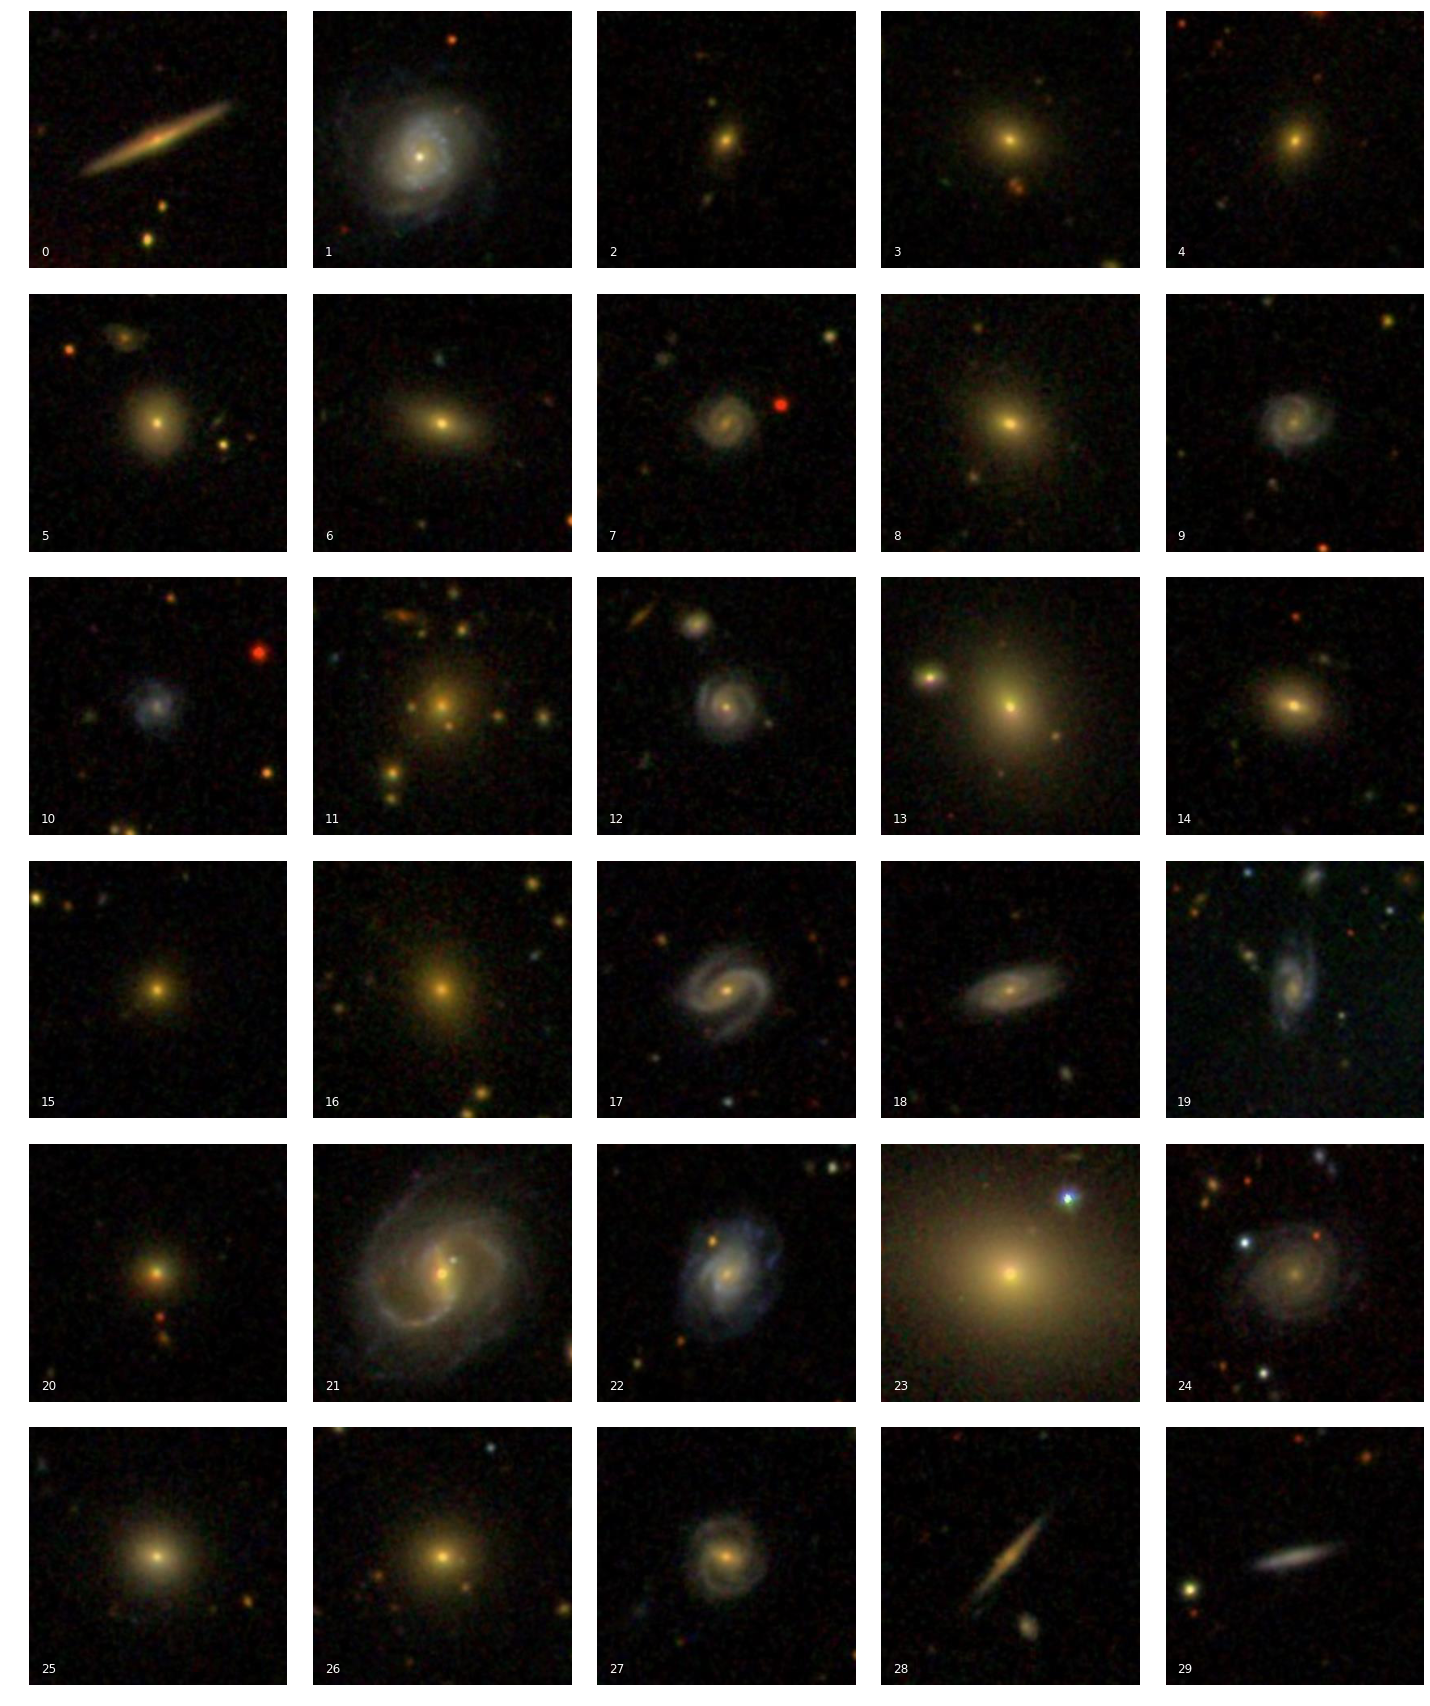

In [176]:
from scipy.misc import imread, imsave

fig, ax = plt.subplots(figsize=(25,30), sharex=True, sharey=True)
for i in range(30):
    ax = plt.subplot(6,5,i+1)
    im_file=im_full[gv[i]]
    im_data=imread(im_file)
    ax.imshow(im_data)
    ax.axis('off')
    ax.text(0.05,0.05, str(i), transform=ax.transAxes, color='white', fontsize=12)

fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.savefig('SDSS_morfologia.jpg', bbox_inches='tight', pad_inches=0)

In [186]:
cat_full.iloc[gv]

ra        dec         u         g         r         i         z
15   14.559486  15.200253  19.02797  17.08535  16.09030  15.55040  15.12846
20  239.705422  14.969193  18.37152  17.46466  17.31059  17.49466  17.23945
7   148.919480   4.493942  20.81122  18.80297  17.57092  17.07555  16.72780
14  168.413512  59.293458  19.23900  17.28332  16.19314  15.72651  15.35783
5   250.556037  21.984739  20.13382  18.01895  16.80676  16.32159  15.92186
3   122.157713  19.304330  18.78819  16.79565  15.86990  15.43240  15.10621
6   183.193739  34.269499  18.89390  16.90068  15.90126  15.47297  15.11380
29  160.539544  65.101534  19.07532  17.75013  16.90090  16.48999  16.16319
12  185.754353  61.707158  18.70965  16.63571  15.61255  15.16839  14.79017
23  176.343264  25.647088  18.71480  17.46571  16.77394  16.43784  16.16055
21  167.414887  19.294677  19.30394  18.09272  17.70576  17.45160  17.36353
1   180.871532  33.676015  19.57773  17.54818  16.22724  15.72687  15.42532
24  175.690673  10.288394  17.75298  16.77014  16.13074  15.73672  15.51232
0   217.002390  37.400913  17.58736  15.60366  14.69556  14.28900  13.96379
8   135.478406  55.065119  18.74596  16.75307  15.86211  15.41807  15.08230
4   148.920224  30.761665  20.48265  18.37696  17.03156  16.53907  16.18664
2   143.376448  47.961210  19.24883  17.25740  15.95120  15.50748  15.08461
16  236.819675  20.441324  17.75722  16.36159  15.66167  15.24168  14.95334
28  181.481788  49.044562  18.36776  16.95193  16.30774  15.90707  15.66432
22  119.480724  28.046045  19.35499  17.70389  17.13966  16.85838  16.71841
9   126.571865  47.076243  19.88142  17.80997  16.72737  16.24957  15.88377
25  208.944951  25.840363  17.41662  15.28958  14.32949  13.86652  13.58836
19  255.074418  38.392734  17.40394  16.02719  15.52810  15.22465  15.02496
10  235.647922  23.670054  15.98356  14.07919  13.22432  12.81408  12.48401
27  233.191302  29.526621  18.69291  17.05149  16.34424  16.03720  15.84347
11  166.247425  30.107216  17.82685  16.16346  15.37921  15.00173  14.74016
13  230.413123  31.677445  18.71027  16.65968  15.63141  15.18913  14.81320
26  170.491140   8.573156  18.46061  16.84169  15.94783  15.50005  15.16213
17  168.204905   1.874199  20.25491  18.56362  17.60125  17.08380  16.71185
18  219.929026  23.656253  19.02137  17.85595  17.41455  17.10028  16.89018

In [185]:
(cat_full.iloc[gv]).to_csv('SDSS_galaxyzoo_morfologia.csv',index=False)

In [193]:
a=[1,2,3]
cat_full['u'].iloc[a]+2

21.204916666666666